# Generating music with GTZAN and Keras
Let's generate some music! A lot of techniques I've seen around use symbolic methods (generate tabs / midi), but I think giving the model full control over the waveform is a lot more challenging and potentially a lot more fun / cooler. The model architecture I'll be using is very inspired by [this awesome example in the keras docs](https://keras.io/examples/generative/ddim/), which I highly recommend taking a look at if you want to learn more about diffusion models

Let's start off by pinning our version of librosa so that our logs look reasonable (skip this step at your own risk)

# Explanation of technique
Skip this part if you don't like reading 😆. The overall idea here is to generate music directly from spectrograms (or some kind of 2d representation of the audio data) and then convert the spectrogram back to audio.

### Feature representation
I consider this to be the crux of this whole technique. Because image generation with CNNs is very popular and has been super successful recently (especially with the explosive progress made recently with diffusion models). The way I use the audio data is by using a [Modified Discrete Cosine Transform (MDCT)](https://www.tensorflow.org/api_docs/python/tf/signal/mdct). Using this particular transform is useful because you can exactly reconstruct your audio waveform from the MDCT spectrogram by applying the inverse MDCT transform. It's also useful because, unlike the fourier transform, all of the values that come from the MDCT transform are real valued. That way, you don't have to fool around with trying to reconstruct the phase of your new signal. This is what allows us to take advantage of 2d convolutional neural networks in order to create a 2d spectrogram and convert it directly to audio.  

### Model Architecture
I chose U-net, mostly because it seems to be the standard choice for training Diffusion models. I add attention in the bottom upsampling layer. Would be cool to try adding attention to more parts of this model and see how it affects the generated examples. I've intended to, but tend to OOM the GPU when I do. Happy to hear suggestions.

### Training & Sampling
In my own personal experiments, I've tried a few different generative models for this task. This includes several types of GAN and VAE models. It seems like diffusion works (by far) much better. I (once again) borrow [this implementation of Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/) (seriously, take a read if you're interested. I find it to be very practical and digestable). I pretty arbitrarily choose 1000 diffusion steps for sampling. Maybe more is better? Maybe less? Worth playing with more

In [1]:
!pip install librosa==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201396 sha256=22df88f29d76f766d124fc6800b9b2a4b1fcefc6e23ade6c78fe17b38aeae323
  Stored in directory: /root/.cache/pip/wheels/de/1e/aa/d91797ae7e1ce11853ee100bee9d1781ae9d750e7458c95afb
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.9.2
    Uninstalling librosa-0.9.2:
      Successfully uninstalled librosa-0.9.2


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa 
from glob import glob

import random
from functools import partial
import warnings
import IPython.display as ipd
from tensorflow.keras import mixed_precision
warnings.filterwarnings('ignore')

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Pick some files to train on

I've found that this doesn't work so well if you try to train the model on all genres at once. So let's pick a single genre. I'll pick classical for now

In [4]:
music_files = glob("/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/*.*.wav")
music_files[:10]

['/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00047.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00021.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00031.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00095.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00012.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00027.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00049.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00088.wav',
 '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/classical.00054.wav',
 '/kaggle/

## Define keras layers
Define the layers we'll use to build our model.

In [5]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    embedding_max_frequency = 1000.0
    embedding_dims = 32
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth, attention=False):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            skip = skips.pop()
            x = layers.Concatenate()([x, skip] if not attention else [
                x, skip, layers.MultiHeadAttention(
                    num_heads=4, key_dim=1, attention_axes=(1,2)
                )(x, skip)
            ])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(widths, block_depth, dim1=256, dim2=128, channels=1, attention=False):
    noisy_input = keras.Input(shape=(dim1, dim2, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))
    
    upsample_shape = (dim1, dim2)

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=upsample_shape, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for idx, width in enumerate(reversed(widths[:-1])):
        x = UpBlock(width, block_depth, attention=attention and idx ==0)([x, skips])

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_input, noise_variances], x, name="residual_unet")

## Define Model
Here, we'll build our model

In [6]:
min_signal_rate = 0.02
max_signal_rate = 0.95
ema = 0.999

def spectral_norm(pred, real):
    """Calculate difference in spectral norm between two batches of spectrograms."""
    norm_real = tf.norm(real, axis=(1,2)) + 1e-6
    norm_pred = tf.norm(pred, axis=(1,2)) + 1e-6
    return tf.reduce_mean(tf.abs(norm_real - norm_pred) / norm_real)

def time_derivative(pred, real, window=1):
    real_derivative = real[:, :-window, :, :] - real[:, window:, :, :]
    pred_derivative = pred[:, :-window, :, :] - pred[:, window:, :, :]
    return tf.reduce_mean(tf.keras.losses.MSE(real_derivative, pred_derivative))



class DDIM(keras.Model):
    """DDIM model modified from this tutorial: https://keras.io/examples/generative/ddim/"""
    
    def __init__(self, widths, block_depth, attention=False, dim1=256, dim2=128):
        super().__init__()

        self.normalizer = layers.Normalization(axis=(2,3))
        self.network = get_network(widths, block_depth, attention=attention, dim1=dim1, dim2=dim2)
        self.ema_network = keras.models.clone_model(self.network)
        self.spec_mod = 0
        self.dx_mod = 0

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.data_loss_tracker = keras.metrics.Mean(name="d_loss")
        
        self.noise_spec_tracker = keras.metrics.Mean(name="n_spec")
        self.data_spec_tracker = keras.metrics.Mean(name="d_spec")
        
        self.noise_dx_tracker = keras.metrics.Mean(name="n_dx")
        self.data_dx_tracker = keras.metrics.Mean(name="d_dx")
        
        self.noise_total_tracker = keras.metrics.Mean(name="n_total")
        self.data_total_tracker = keras.metrics.Mean(name="d_total")

    @property
    def metrics(self):
        return [
            self.noise_loss_tracker, 
            self.data_loss_tracker,
            
            self.noise_spec_tracker,
            self.data_spec_tracker,
            
            self.noise_dx_tracker,
            self.data_dx_tracker,
            
            self.noise_total_tracker,
            self.data_total_tracker
        ]
    
    def update_trackers(self, n_l, n_s, n_d, d_l, d_s, d_d):
        """Update all loss trackers."""
        n_t = n_l + n_s + n_d
        d_t = d_l + d_s + d_d
        
        for loss, tracker in zip(
            [n_l, n_s, n_d, n_t, d_l, d_s, d_d, d_t], 
            [
                self.noise_loss_tracker, self.noise_spec_tracker, self.noise_dx_tracker, self.noise_total_tracker,
                self.data_loss_tracker, self.data_spec_tracker, self.data_dx_tracker, self.data_total_tracker
            ]
        ):
            tracker.update_state(loss)
            
    def get_losses(self, y_true, y_pred):
        """Get losses for model."""
        return (
            tf.reduce_mean(
                self.loss(y_pred, y_true)
            ), spectral_norm(
                y_pred, y_true
            ), time_derivative(
                y_pred, y_true
            )
        )

    def denormalize(self, data):
        data = self.normalizer.mean + data * self.normalizer.variance**0.5
        return tf.clip_by_value(data, -128.0, 128.0)

    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        return noise_rates, signal_rates

    def denoise(self, noisy_data, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network([noisy_data, noise_rates**2], training=training)
        pred_data = (noisy_data - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_data

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_examples = tf.shape(initial_noise)[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy data" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_data = initial_noise
        for step in tqdm(range(diffusion_steps)):
            noisy_data = next_noisy_data

            # separate the current noisy data to its components
            diffusion_times = tf.ones((num_examples, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_data = self.denoise(
                noisy_data, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_data = (
                next_signal_rates * pred_data + next_noise_rates * pred_noises
            )
            # this new noisy data will be used in the next step

        return pred_data

    def generate(self, num_examples, shape, diffusion_steps):
        # noise -> data -> denormalized data
        initial_noise = tf.random.normal(shape=(num_examples, shape[0], shape[1], shape[2]))
        generated_data = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_data = self.denormalize(generated_data)
        return generated_data

    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        # normalize data to have standard deviation of 1, like the noises
        data = self.normalizer(data, training=True)
        noises = tf.random.normal(shape=tf.shape(data))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noise_rates = noise_rates
        signal_rates = signal_rates
        # mix the data with noises accordingly
        noisy_data = signal_rates * data + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy data to their components
            pred_noises, pred_data = self.denoise(
                noisy_data, noise_rates, signal_rates, training=True
            )

            noise_loss, noise_spec, noise_dx = self.get_losses(noises, pred_noises) #safe_reduce_mean(self.loss(noises, pred_noises))  # used for training
            total_noise_loss = tf.reduce_sum([
                noise_loss, 
                self.spec_mod*noise_spec, 
                self.dx_mod*noise_dx
            ])
            data_loss, data_spec, data_dx = self.get_losses(data, pred_data) #safe_reduce_mean(self.loss(data, pred_data))  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.update_trackers(
            noise_loss, noise_spec, noise_dx,
            data_loss, data_spec, data_dx
        )

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # normalize data to have standard deviation of 1, like the noises
        batch_size = tf.shape(data)[0]
        
        data = self.normalizer(data, training=False)
        noises = tf.random.normal(shape=tf.shape(data))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the data with noises accordingly
        noisy_data = signal_rates * data + noise_rates * noises

        # use the network to separate noisy data to their components
        pred_noises, pred_data = self.denoise(
            noisy_data, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        data_loss = self.loss(data, pred_data)

        self.data_loss_tracker.update_state(data_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

## Define data loader

Here we're going to make some data loading utils and then define our dataset

In [7]:
def load_at_interval(x, rate=10_000, feats=256, duration=3.3):
    """Load music from file at some offset. Return MDCT spectrogram of that data"""
    file = x[0].numpy().decode()
    idx = x[1].numpy()
    audio, sr = librosa.load(file, duration=duration, sr=rate, offset=idx)
    audio_fill = np.zeros(int(rate*duration), dtype=np.float32)
    audio_fill[:len(audio)] = audio
    spec = tf.signal.mdct(audio_fill, feats)
    return spec

def load_audio(x,y, rate=10_000, mdct_feats=256, duration=3.3):
    """TF function for loading MDCT spectrogram from file."""
    out = tf.py_function(lambda x,y: load_at_interval( 
        (x,y), rate=rate, feats=mdct_feats, duration=duration
    ), inp=[x,y], Tout=tf.float32)
    return out

def get_files_dataset(
        glob_location,
        total_seconds=2,
        out_len = 3.3,
        hop_size=1,
        max_feats = 2048,
        batch_size=4,
        shuffer_size=1000,
        scale=1,
        rate=10_000,
        mdct_feats=256
    ):
    """Get file dataset loader for a glob of audio files."""
    
    files = glob(
        glob_location,
        recursive=True
    )
    
#     files = [file for file in files if file not in exclude]
    
    def file_list_generator():
        for _ in range(total_seconds):
            for file in files:
                yield file, _*hop_size
                
    load_fn = partial(load_audio, duration=out_len, rate=rate, mdct_feats=mdct_feats)
                
    dg =tf.data.Dataset.from_generator(file_list_generator, output_signature = (
        tf.TensorSpec(shape=(), dtype=tf.string), 
        tf.TensorSpec(shape=(), dtype=tf.int32))).shuffle(shuffer_size).map(
            load_fn, num_parallel_calls=tf.data.AUTOTUNE
        ).map(
            lambda x: tf.expand_dims(x, -1)[:max_feats, :, :]*scale
        ).map(
            lambda x: tf.ensure_shape(x, (max_feats, mdct_feats//2, 1))
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dg

## Putting it all together

In [8]:
dataset = get_files_dataset(
    "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/classical/*.wav", 
    out_len=3.3, 
    max_feats=256, 
    total_seconds=26, 
    scale=1,
    batch_size=16
)

In [9]:
for test_batch in dataset.take(1):
    shape = test_batch.shape

print(shape)

(16, 256, 128, 1)


In [10]:
num_total_examples = (len(music_files) * 26) // shape[0]

In [11]:
model = DDIM(widths = [128, 128, 128, 128], block_depth = 2, 
             attention=True, dim1=shape[1], dim2=shape[2])

In [12]:
model.normalizer.adapt(dataset, steps=10)

In [13]:
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer= tfa.optimizers.AdamW(
        learning_rate = 3e-4,
        weight_decay = 1e-4
    )
)

In [14]:
dataset = dataset.cache()

In [15]:
history = model.fit(dataset.repeat(), steps_per_epoch=num_total_examples, epochs=1)

162/162 [==============================] - 238s 1s/step - n_loss: 0.1982 - d_loss: 1.9320 - n_spec: 0.1573 - d_spec: 2.0565 - n_dx: 0.3876 - d_dx: 3.6625 - n_total: 0.7431 - d_total: 7.6510


In [16]:
model.spec_mod = 1
model.dx_mod = 1

In [17]:
history = model.fit(dataset.repeat(), steps_per_epoch=num_total_examples, epochs=100)

Epoch 1/100
162/162 [==============================] - 227s 1s/step - n_loss: 0.1341 - d_loss: 0.6848 - n_spec: 0.1016 - d_spec: 1.1743 - n_dx: 0.2619 - d_dx: 1.3060 - n_total: 0.4976 - d_total: 3.1651
Epoch 2/100
162/162 [==============================] - 122s 749ms/step - n_loss: 0.1209 - d_loss: 0.5537 - n_spec: 0.0878 - d_spec: 0.9267 - n_dx: 0.2362 - d_dx: 1.0626 - n_total: 0.4448 - d_total: 2.5429
Epoch 3/100
162/162 [==============================] - 121s 747ms/step - n_loss: 0.1190 - d_loss: 0.4680 - n_spec: 0.0848 - d_spec: 0.8263 - n_dx: 0.2328 - d_dx: 0.8637 - n_total: 0.4366 - d_total: 2.1579
Epoch 4/100
162/162 [==============================] - 121s 747ms/step - n_loss: 0.1163 - d_loss: 0.4262 - n_spec: 0.0776 - d_spec: 0.6933 - n_dx: 0.2272 - d_dx: 0.7959 - n_total: 0.4211 - d_total: 1.9154
Epoch 5/100
162/162 [==============================] - 121s 746ms/step - n_loss: 0.1146 - d_loss: 0.4535 - n_spec: 0.0802 - d_spec: 0.7086 - n_dx: 0.2243 - d_dx: 0.8553 - n_total: 0.4

## Generate new samples using this model

In [18]:
specs = model.generate(8, shape[1:], 1000)

100%|██████████| 1000/1000 [02:36<00:00,  6.40it/s]


### Let's look at some real examples first, to get an idea of what we're looking for

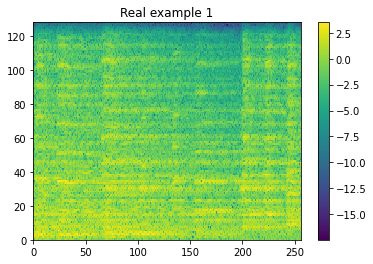

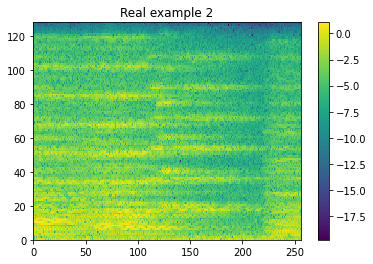

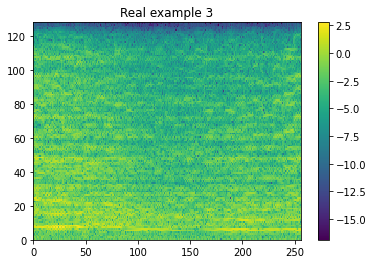

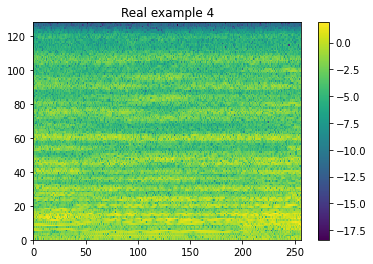

In [19]:
for i in range(4):
    plt.pcolormesh(np.log(np.abs(test_batch[i, :, :, 0].numpy().T)))
    plt.colorbar()
    plt.title(f"Real example {i+1}")
    plt.show()
    ipd.display(ipd.Audio(tf.signal.inverse_mdct(test_batch[i, :, :, 0]), rate=10_000))

### Now let's compare the generated samples

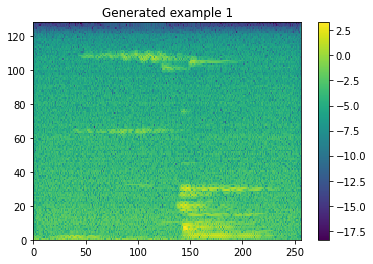

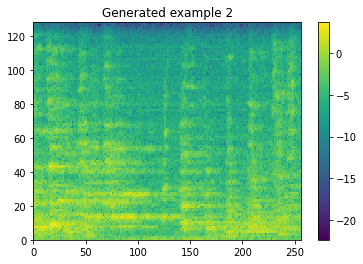

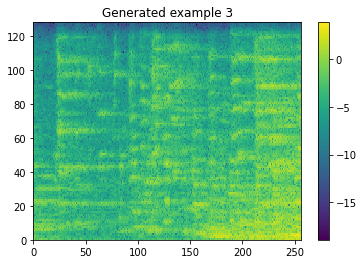

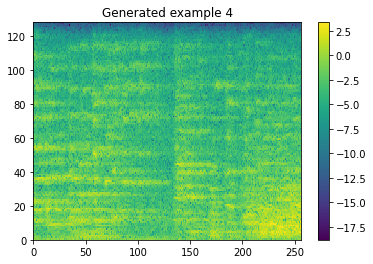

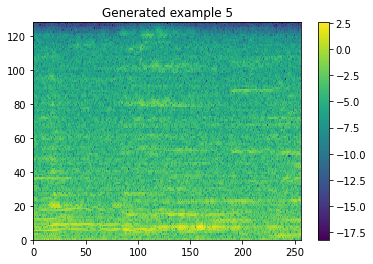

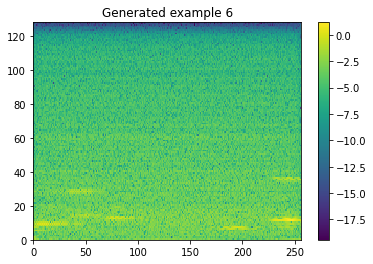

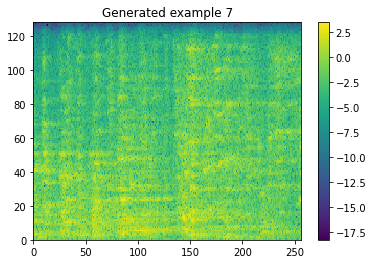

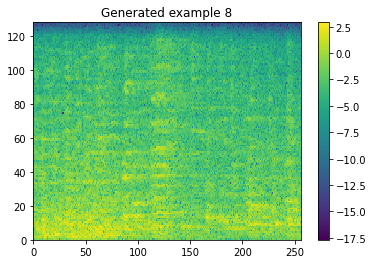

In [20]:
for i in range(len(specs)):
    plt.pcolormesh(np.log(np.abs(specs[i, :, :, 0].numpy().T)))
    plt.colorbar()
    plt.title(f"Generated example {i+1}")
    plt.show()
    ipd.display(ipd.Audio(tf.signal.inverse_mdct(tf.cast(specs[i, :, :, 0], tf.float32)), rate=10_000))

## Ideas for improvement

Samples were interesting, but definitely far from great! There's a lot of room for improvement here. I've got a few ideas, but there are surely more. 

- Train for longer
- Scale up the model
- Scale up the dataset
- Train on longer pieces of audio
- Data augmentation (ex: phase inversion)
- Weight the loss by perceived volume of frequencies (psychoacoustic features)? 
- Same thing, but using 1d signal instead? (not sure if this would actually help)
- Play with sampling?